# 1. Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import random
import torchvision

from typing import List, Dict, Tuple
from torch import nn
from torchvision.transforms import transforms
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from datetime import datetime

from helper_functions import create_dataloaders, set_seeds, display_random_images, plot_loss_curves, save_model, load_model
from engine import train, create_writer

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_baseline': True,
    'save_baseline':  True,    
}

# Define target data directory
#target_dir_name = f"../data/pizza_steak_sushi_applepie_hamburger_{str(int(AMOUNT_TO_GET*100))}_percent"
target_dir_name = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Create image size
IMG_SIZE = 224

manual_transforms = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.TrivialAugmentWide(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.TrivialAugmentWide(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

pretrained_resnetb0_transforms = torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()

In [4]:
print(f"Default EfficientNetB0 transforms: {pretrained_resnetb0_transforms}")

Default EfficientNetB0 transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
# Setup the directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

# Create data loaders
train_dataloader_b0, test_dataloader_b0, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=pretrained_resnetb0_transforms,
    test_transform=pretrained_resnetb0_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader_b0, test_dataloader_b0, class_names

(<torch.utils.data.dataloader.DataLoader at 0x22088996dd0>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot

# 3. Image Visualization

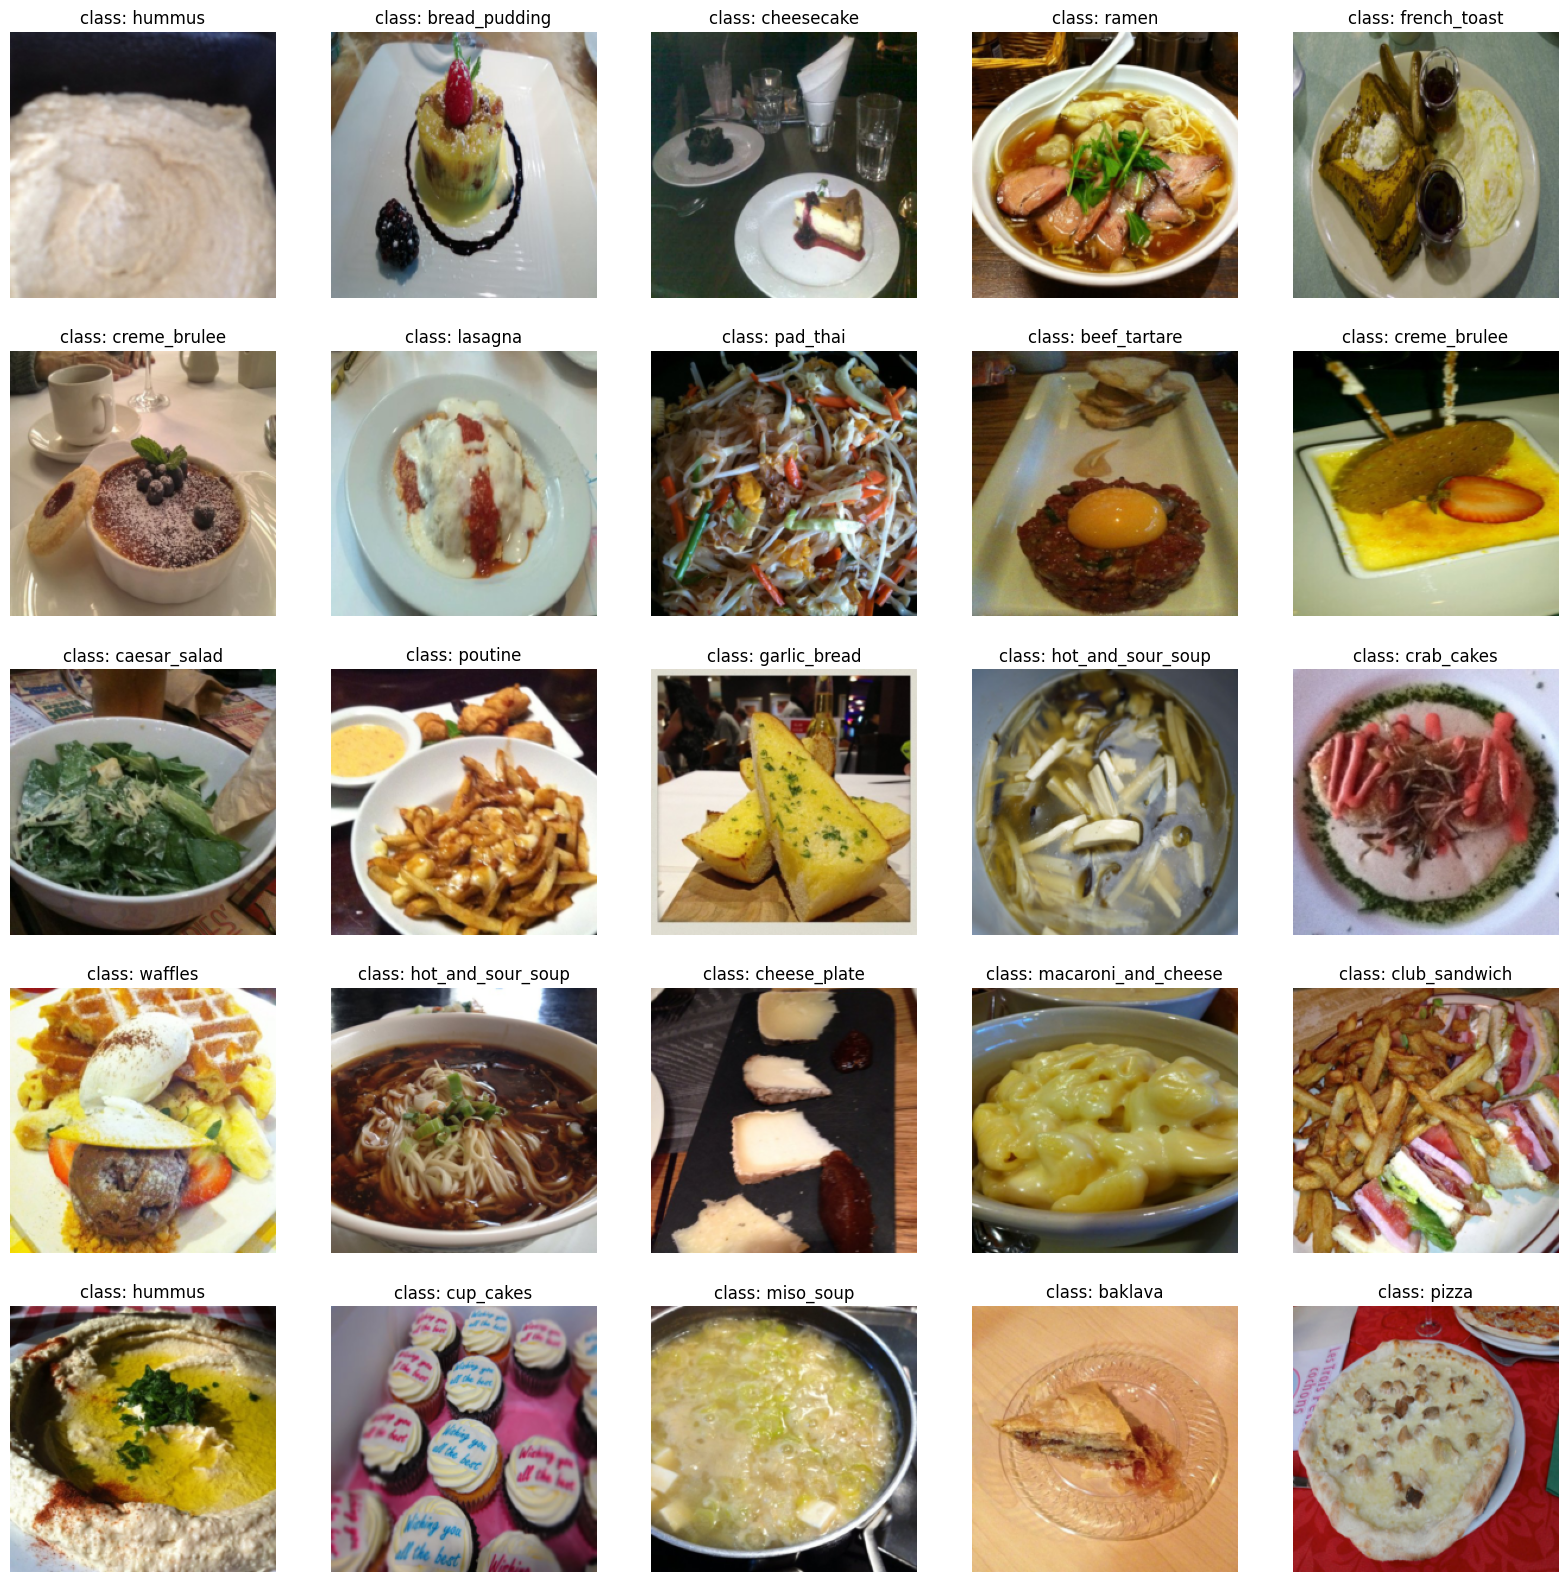

In [6]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 4. Baseline Model: EfficientNet B0

## 4.1 Create and Instantiate the Model

In [7]:
# Create an EfficientNet-B0 Model
def create_effnetb0(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB0 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    if transfer_learning:
        weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
        
    return model, weights

# Instantiate the model
effnetb0_model, effnetb0_weights = create_effnetb0(class_names=class_names)

# Print its architecture
print(effnetb0_model)

# And a summary
summary(effnetb0_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4.2 Train the Model

Model name: effnetb0_lr0010_30epochs
Model path: effnetb0_lr0010_30epochs.pth
Results path: effnetb0_lr0010_30epochs.csv
[INFO] Created SummaryWriter, saving to: runs\2024-11-28\data_100_percent\effnetb0_lr0010_30epochs\30_epochs...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5348 | train_acc: 0.4161 | test_loss: 1.7896 | test_acc: 0.5558
Epoch: 2 | train_loss: 2.0214 | train_acc: 0.5051 | test_loss: 1.6554 | test_acc: 0.5838
Epoch: 3 | train_loss: 1.9365 | train_acc: 0.5234 | test_loss: 1.6367 | test_acc: 0.5854
Epoch: 4 | train_loss: 1.8812 | train_acc: 0.5331 | test_loss: 1.6191 | test_acc: 0.5905
Epoch: 5 | train_loss: 1.8480 | train_acc: 0.5381 | test_loss: 1.6101 | test_acc: 0.5913
Epoch: 6 | train_loss: 1.8382 | train_acc: 0.5414 | test_loss: 1.5875 | test_acc: 0.5958
Epoch: 7 | train_loss: 1.8179 | train_acc: 0.5445 | test_loss: 1.5768 | test_acc: 0.5991
Epoch: 8 | train_loss: 1.8092 | train_acc: 0.5452 | test_loss: 1.5761 | test_acc: 0.5957
Epoch: 9 | train_loss: 1.8050 | train_acc: 0.5459 | test_loss: 1.5961 | test_acc: 0.5935
Epoch: 10 | train_loss: 1.7959 | train_acc: 0.5477 | test_loss: 1.5802 | test_acc: 0.5981
Epoch: 11 | train_loss: 1.8007 | train_acc: 0.5493 | test_loss: 1.5862 | test_acc: 0.5966
Epoch: 12 | train_l

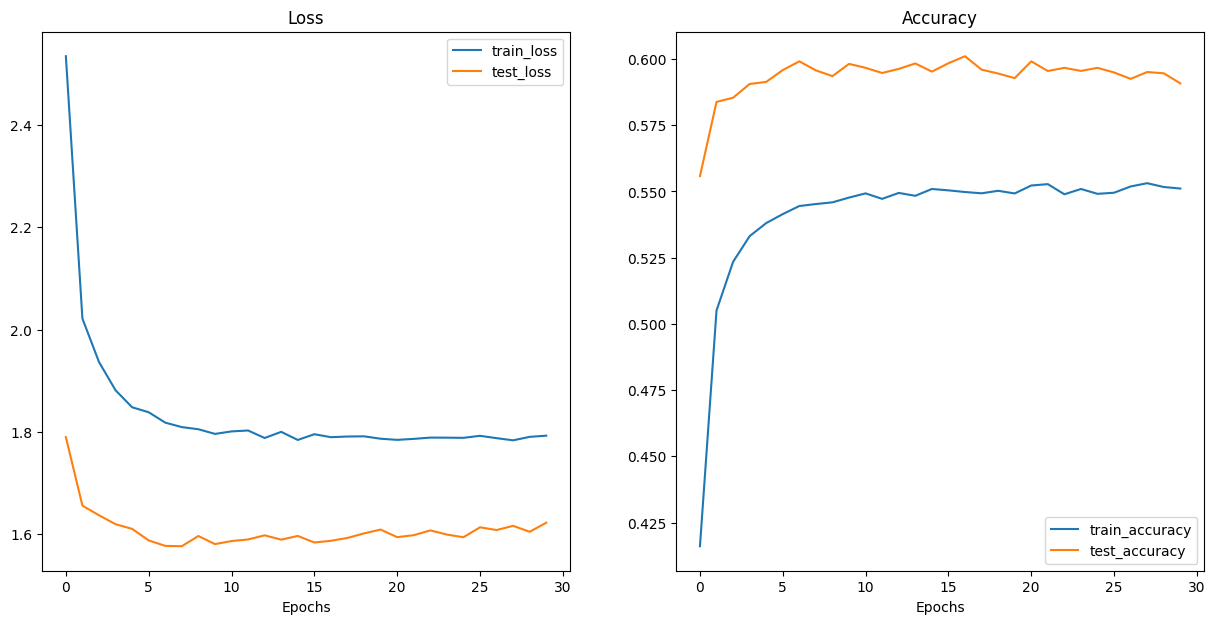

In [8]:
model_type="effnetb0"
EPOCHS = 30
LR = 0.001
model_name = f"{model_type}_lr{int(LR * 10000):04d}_{EPOCHS}epochs"
effnetb0_model_name = model_name + ".pth"
effnetb0_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb0_model_name}")
print(f"Results path: {effnetb0_results_df}")

# Train the model
if ENABLE['train_baseline']:
    # Create an example writer
    effnetb0_writer = create_writer(experiment_name="data_100_percent",
                                model_name=model_name,
                                extra=f"{EPOCHS}_epochs")
    
    # Create optimizer and loss function
    optimizer = torch.optim.Adam(params=effnetb0_model.parameters(),
                                lr=LR,
                                #betas=(0.9, 0.999),
                                #weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k
    )

    loss_fn = torch.nn.CrossEntropyLoss()

    # Train the classifier
    set_seeds(SEED)
    effnetb0_results = train(model=effnetb0_model,
                             train_dataloader=train_dataloader_b0,
                             test_dataloader=test_dataloader_b0,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=EPOCHS,
                             device=device,
                             writer=effnetb0_writer)
    
    plot_loss_curves(effnetb0_results)

In [9]:
# Save the EfficientNet B0 model
if ENABLE['save_baseline']:
   save_model(model=effnetb0_model,
              target_dir=model_dir,
              model_name=effnetb0_model_name)
   df_results = pd.DataFrame(effnetb0_results)
   df_results.to_csv(os.path.join(model_dir, effnetb0_results_df), index=False)  

[INFO] Saving model to: ..\models\effnetb0_lr0010_30epochs.pth


## 4.3 Training Results

In [10]:
# Instantiate the model
effnetb0_model, effnetb0_weights = create_effnetb0(class_names=class_names)

# Load the trained weights
effnetbo_model = load_model(model=effnetb0_model,
                            model_weights_dir=model_dir,
                            model_weights_name=effnetb0_model_name)

# Load the training results
effnetb0_results = pd.read_csv(os.path.join(model_dir, effnetb0_results_df))

[INFO] Loading model from: ..\models\effnetb0_lr0010_30epochs.pth


In [11]:
test_acc = effnetb0_results['test_acc'].iloc[-1]
test_los = effnetb0_results['test_loss'].iloc[-1]
model_size = Path(os.path.join(model_dir, effnetb0_model_name)).stat().st_size // (1024*1024)
print(f"Accuracy on the test set: {test_acc}")
print(f"Loss on the test set: {test_los}")
print(f"Model size: {model_size} MB")

Accuracy on the test set: 0.5907832278481012
Loss on the test set: 1.6220746599355875
Model size: 16 MB
